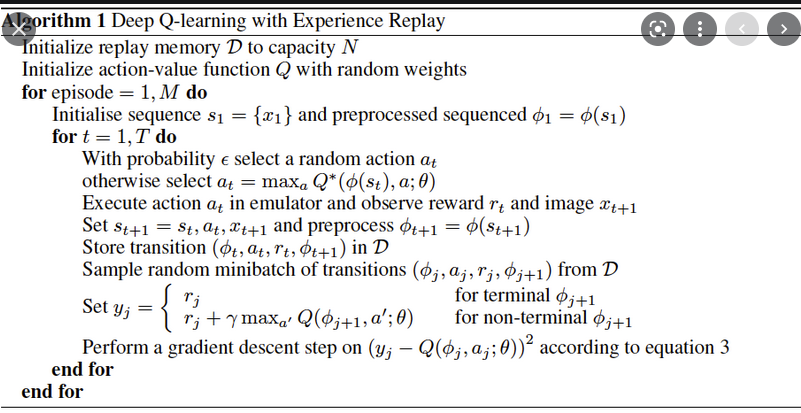

In [34]:
from MachineEnv import *  #Get Machine Env Parameters and Libraries
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.specs import tensor_spec
from tf_agents.networks import sequential
from tf_agents.trajectories import time_step as ts
from machine import Machine
import tf_agents
import random
import matplotlib
import matplotlib.pyplot as plt

Initiate Machine

In [35]:
mach = Machine()
mach.curr_state = 0

In [36]:
reward_func = {0:1000,1:900,2:800,3:500,4:-500,5:-500,6:-500,7:-500,8:-3000,9:-1000}

Build Custom env

In [80]:
class MachineEnv(py_environment.PyEnvironment):
    
    def __init__(self,machine,tm,reward):
        self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=0, maximum=1, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(shape=(4,), dtype=np.float64, minimum= -1, maximum = 1, name='observation') #defines observation characterisitcs
        
        self.machine = machine #assumes that initialise machine state as 0 alr
        self.hidd_state = 0
        self._state = self.machine.readSensors() #observation is the _state
        self.trans = tm
        self.steps = 0
        self._episode_ended = False
        self.reward_func = reward
        
    def action_spec(self):
        return self._action_spec
    
    def observation_spec(self):
        return self._observation_spec
    
    def _reset(self):
        self.hidd_state = np.random.randint(0,4,1)[0]
        #self.hidd_state = 0
        self.machine.curr_state = self.hidd_state
        self._state = self.machine.readSensors()
        self.steps = 0
        self._episode_ended = False
        return ts.restart(np.array(self._state, dtype=np.float64))
    
    def _step(self, action):
        if self._episode_ended:
          # The last action ended the episode. Ignore the current action and start
          # a new episode.
            return self.reset()
        
        transition_mat_action = self.trans[action]
        nxt_state = np.random.choice([i for i in range(10)],1,p=transition_mat_action[self.hidd_state])[0] #select nxt state based on prob
        
        self.hidd_state = nxt_state
        reward = self.reward_func[nxt_state] #immediate rewards from state trans
        
        self.machine.curr_state = self.hidd_state
        self._state = self.machine.readSensors()
        
        while(self.machine.curr_state in [4,5,6,7]): #cumulative reward during maintenance
            transition_mat_action = self.trans[0] #default action 0 in maintenance state
            nxt_state = np.random.choice([i for i in range(10)],1,p=transition_mat_action[self.hidd_state])[0] #select nxt state based on prob
            self.hidd_state = nxt_state
            self.machine.curr_state = self.hidd_state
            self._state = self.machine.readSensors()
            reward+=self.reward_func[nxt_state]
            
        self.steps += 1
        
#         #Episode Ver 1
#         if(self.steps == 50):
#             self._episode_ended = True
        
        #Episode Ver 2
        if self.machine.curr_state in [8,9] or self.steps >= 100:
            self._episode_ended = True
        
        
        if self._episode_ended:
            return ts.termination(np.array(self._state, dtype=np.float64), reward)
        
        else:
            return ts.transition(np.array(self._state, dtype=np.float64), reward=reward, discount=1.0) #no discount

In [81]:
env = MachineEnv(mach,tm,reward_func)
env.machine
env = tf_py_environment.TFPyEnvironment(env)

Could use the standard dense layer (128,64)\
Could be modified to DQRN by adding additional LSTM layer

q_net = q_network.QNetwork(env.observation_spec(), 
                           env.action_spec())

In [82]:
# from tf_agents.networks import sequential
# fc_layer_params = (128, 64)
# action_tensor_spec = tensor_spec.from_spec(env.action_spec())
# num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# # Define a helper function to create Dense layers configured with the right
# # activation and kernel initializer.
# def dense_layer(num_units):
#     return tf.keras.layers.Dense(
#       num_units,
#       activation=tf.keras.activations.relu,
#       kernel_initializer=tf.keras.initializers.VarianceScaling(
#     scale=2.0, mode='fan_in', distribution='truncated_normal'))

# # QNetwork consists of a sequence of Dense layers followed by a dense layer
# # with `num_actions` units to generate one q_value per available action as
# # its output.
# lstm_layer = tf.keras.layers.LSTM(128,return_sequences=True,return_state=True)
# dropout_layer = tf.keras.layers.Dropout(0.2)

# q_values_layer = tf.keras.layers.Dense(
#     num_actions,
#     activation=None,
#     kernel_initializer=tf.keras.initializers.RandomUniform(
#         minval=-0.03, maxval=0.03),
#     bias_initializer=tf.keras.initializers.Constant(-0.2))

# q_net = sequential.Sequential([lstm_layer,dropout_layer,dense_layer(fc_layer_params[0]),dense_layer(fc_layer_params[1]),q_values_layer])


In [83]:
q_net = tf_agents.networks.q_rnn_network.QRnnNetwork(env.observation_spec(), env.action_spec(),input_fc_layer_params=(128, 64),lstm_size = [32,16])

In [84]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001)

In [85]:

train_step_counter = tf.Variable(0)

agent = tf_agents.agents.dqn.dqn_agent.DqnAgent(env.time_step_spec(),
                                                env.action_spec(),
                                                q_network=q_net,
                                                optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=0.001),
                                                td_errors_loss_fn=tf_agents.utils.common.element_wise_squared_loss,
                                                target_update_period =500 , #update target network after 1000 TS
                                                train_step_counter=train_step_counter)

agent.initialize()

replay_buffer = tf_agents.replay_buffers.tf_uniform_replay_buffer.TFUniformReplayBuffer(data_spec=agent.collect_data_spec,
                                                                                        batch_size=env.batch_size,
                                                                                        max_length=100000)

In [86]:
def compute_avg_return(environment, policy, num_episodes):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0 
        while not time_step.is_last():
            action_step = policy.action(time_step, policy.get_initial_state(batch_size=1))
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return   
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]# Evaluate the agent's policy once before training.

avg_return = compute_avg_return(env, agent.policy, 20)
returns = [avg_return]

In [87]:
# replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
#                                 data_spec=agent.collect_data_spec,                                                                
#                                 batch_size=env.batch_size,                                                              
#                                 max_length=100000)

def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step, policy.get_initial_state(batch_size=1))
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, 
                                      action_step, 
                                      next_time_step)# Add trajectory to the replay buffer
    buffer.add_batch(traj)

In [88]:
collect_steps_per_iteration = 1
trial_step = 20
batch_size = 64
dataset = replay_buffer.as_dataset(num_parallel_calls=3, 
                                    sample_batch_size=batch_size, 
                                    num_steps=2).prefetch(3)
iterator = iter(dataset)
num_iterations = 50000
env.reset()

for _ in range(batch_size):
    collect_step(env, agent.policy, replay_buffer)

for _ in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    # Print loss every 200 steps.
    if step % 200 == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    # Evaluate agent's performance every 1000 steps.
    if step % 1000 == 0:
        avg_return = compute_avg_return(env, agent.policy, trial_step)
        print('step = {0}: Average Return = {1} over {2} steps'.format(step, avg_return,trial_step))
        returns.append(avg_return)

step = 200: loss = 906510.1875
step = 400: loss = 584922.1875
step = 600: loss = 488291.28125
step = 800: loss = 1693474.75
step = 1000: loss = 1322769.25
step = 1000: Average Return = 1380.0 over 20 steps
step = 1200: loss = 918336.6875
step = 1400: loss = 1614485.25
step = 1600: loss = 969839.1875
step = 1800: loss = 2479470.0
step = 2000: loss = 2084304.75
step = 2000: Average Return = 2260.0 over 20 steps
step = 2200: loss = 1357205.0
step = 2400: loss = 1538699.0
step = 2600: loss = 1582363.0
step = 2800: loss = 3866808.5
step = 3000: loss = 2293406.25
step = 3000: Average Return = 2270.0 over 20 steps
step = 3200: loss = 1136166.75
step = 3400: loss = 1000647.125
step = 3600: loss = 930102.0625
step = 3800: loss = 3454628.0
step = 4000: loss = 2250108.75
step = 4000: Average Return = 575.0 over 20 steps
step = 4200: loss = 511650.125
step = 4400: loss = 4138170.0
step = 4600: loss = 3030991.0
step = 4800: loss = 2888741.0
step = 5000: loss = 3574213.0
step = 5000: Average Return 

step = 39800: loss = 7366043.0
step = 40000: loss = 10308763.0
step = 40000: Average Return = 22090.0 over 20 steps
step = 40200: loss = 9319838.0
step = 40400: loss = 9899959.0
step = 40600: loss = 6042039.5
step = 40800: loss = 12865268.0
step = 41000: loss = 14877520.0
step = 41000: Average Return = 15220.0 over 20 steps
step = 41200: loss = 9847664.0
step = 41400: loss = 5840885.5
step = 41600: loss = 5701824.0
step = 41800: loss = 14442756.0
step = 42000: loss = 15054013.0
step = 42000: Average Return = 19400.0 over 20 steps
step = 42200: loss = 21305848.0
step = 42400: loss = 9373689.0
step = 42600: loss = 13771581.0
step = 42800: loss = 10672738.0
step = 43000: loss = 11842588.0
step = 43000: Average Return = 28325.0 over 20 steps
step = 43200: loss = 5375619.0
step = 43400: loss = 11744756.0
step = 43600: loss = 6918297.0
step = 43800: loss = 11470454.0
step = 44000: loss = 6223437.5
step = 44000: Average Return = 26100.0 over 20 steps
step = 44200: loss = 17112940.0
step = 444

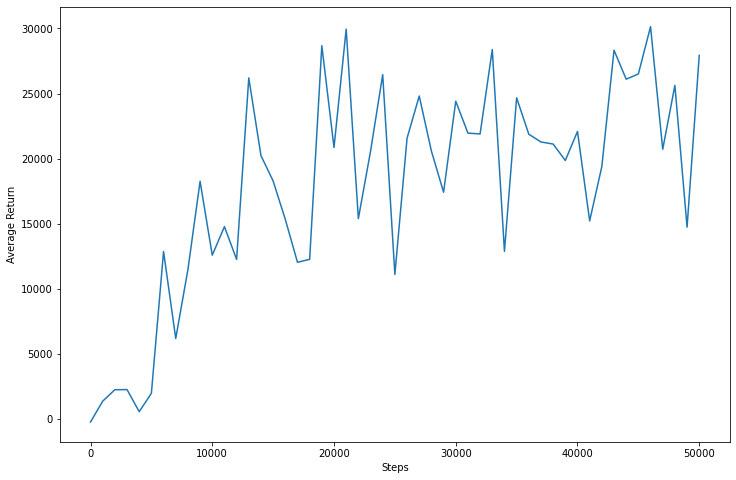

In [89]:
plt.figure(figsize=(12,8))
iterations = [i*1000 for i in range(len(returns))]
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Steps')
plt.show()

In [92]:
from tf_agents.policies import random_tf_policy
mach2 = Machine()
mach2.curr_state = 0
eval_env = MachineEnv(mach2,tm,reward_func)
eval_env = tf_py_environment.TFPyEnvironment(eval_env)
agent.policy
random_policy = random_tf_policy.RandomTFPolicy(env.time_step_spec(),
                                                env.action_spec())

random = []
trained = []

env = MachineEnv(mach,tm,reward_func)
env.machine
env = tf_py_environment.TFPyEnvironment(env)

for i in range(100):
    print(f"Trial {i}")
    x1=compute_avg_return(eval_env, random_policy, 50)
    x2 =compute_avg_return(env, agent.policy, 50)
    print(f"Trial {i}, Random Pol returns: {x1}, Trained Pol returns: {x2}")
    random.append(x1)
    trained.append(x2)
    
iterations = [i for i in range(len(random))]



C:\Users\overl\anaconda3\envs\env1\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.20.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Trial 0
Trial 0, Random Pol returns: 20816.0, Trained Pol returns: 26174.0
Trial 1
Trial 1, Random Pol returns: 19830.0, Trained Pol returns: 16754.0
Trial 2
Trial 2, Random Pol returns: 15590.0, Trained Pol returns: 23800.0
Trial 3
Trial 3, Random Pol returns: 26296.0, Trained Pol returns: 19638.0
Trial 4
Trial 4, Random Pol returns: 14894.0, Trained Pol returns: 25610.0
Trial 5
Trial 5, Random Pol returns: 13850.0, Trained Pol returns: 22542.0
Trial 6
Trial 6, Random Pol returns: 20116.0, Trained Pol returns: 16720.0
Trial 7
Trial 7, Random Pol returns: 20190.0, Trained Pol returns: 17706.0
Trial 8
Trial 8, Random Pol returns: 17280.0, Trained Pol returns: 22638.0
Trial 9
Trial 9, Random Pol returns: 15304.0, Trained Pol returns: 19790.0
Trial 10
Trial 10, Random Pol returns: 17298.0, Trained Pol returns: 21092.0
Trial 11
Trial 11, Random Pol returns: 20386.0, Trained Pol returns: 26132.0
Trial 12
Trial 12, Random Pol returns: 19990.0, Trained Pol returns: 23120.0
Trial 13
Trial 13, 

Test current policy with random policy

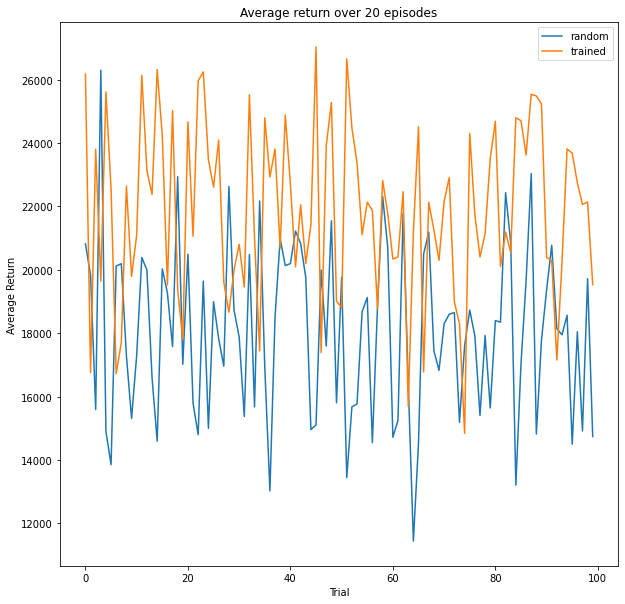

In [93]:
fig = plt.figure(figsize = (10,10))
iterations = [i for i in range(100)]
plt.title("Average return over 20 episodes")
plt.plot(iterations,random,label = 'random')
plt.plot(iterations,trained, label = 'trained')
plt.xlabel('Trial')
plt.ylabel('Average Return')
plt.legend()

plt.show()

# Testing Load and Save policy

In [90]:
from tf_agents.policies import policy_saver
tf_policy_saver = policy_saver.PolicySaver(agent.policy)

In [91]:
tf_policy_saver.save('agent_dqrn.pt')

INFO:tensorflow:Assets written to: agent_dqrn.pt\assets


C:\Users\overl\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\saved_model\nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: agent_dqrn.pt\assets


In [101]:
saved_policy = tf.saved_model.load('agent.pt')
x = env.reset()

In [128]:
action_step = saved_policy.action(x)
print(action_step)
x = env.step(action_step.action)
x

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0])>, state=(), info=())


TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float64, numpy=array([[0.34614702, 0.55103203, 0.22474643, 0.29933351]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([900.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1])>})

In [103]:

saved_policy.action(x).action.numpy()[0]

0

In [111]:
x = np.array([[0.40017584, 0.66184501, 0.20665516, 0.21775512]])
# x = tf_agents.trajectories.TimeStep(step_type = tf.convert_to_tensor(np.array([1])), 
#                                     reward=tf.convert_to_tensor(np.array([0])), 
#                                     discount=tf.convert_to_tensor(np.array([1])),
#                                     observation=tf.convert_to_tensor(np.array(x, dtype=np.float64)))

x = ts.transition(tf.convert_to_tensor(np.array(x, dtype=np.float64)), reward=np.array([0]), discount=np.array([1]))
print(x)
saved_policy.action(x).action.numpy()[0]

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float64, numpy=array([[0.40017584, 0.66184501, 0.20665516, 0.21775512]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1])>})


1

In [ ]:
time = env.reset()
print(time)
x = agent.policy.distribution(time).action
x.prob(1)